# Zarr-multiscales from GeoTiffs

_by Joe Hamman & Jeremy Freeman (CarbonPlan), September 27, 2021, Updated by Max Jones (CarbonPlan), 2024_

This notebook demonstrates the production of Zarr data pyramids for use with
[@carbonplan/maps](https://github.com/carbonplan/maps), an api for interactive
multi-dimensional data-driven web maps.

Some of the libraries used here are in pre-release condition. Specifically
`ndpyramid` and `datatree` are currently udergoing rapid development. Use the
pattern below but expect changes to the specific apis.

All of the libraries used in this demonstration are included in [this conda environment file](https://github.com/carbonplan/ndpyramid/blob/main/ci/environment.yml).


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from ndpyramid import pyramid_reproject

In [2]:
VERSION = 2
LEVELS = 6
PIXELS_PER_TILE = 128
S3 = False
input_path = f"s3://carbonplan-maps/v{VERSION}/demo/raw"
if S3:
    base = f"s3://carbonplan-maps/v{VERSION}/demo/"
    store_2d = base + "2d/tavg"
    store_3d = base + "3d/tavg-prec"
    store_3d_1var = base + "3d/tavg-month"
    store_4d = base + "4d/tavg-prec-month"
else:
    import zarr

    store_2d = zarr.storage.MemoryStore()
    store_3d = zarr.storage.MemoryStore()
    store_3d_1var = zarr.storage.MemoryStore()
    store_4d = zarr.storage.MemoryStore()

## 2d (tavg)

In this example we open a single 2d image (GeoTIFF) and create a Zarr pyramid.


In [3]:
%%time
# input dataset
path = f"{input_path}/wc2.1_2.5m_tavg_10.tif"
# open and extract the input dataset
ds = (
    xr.open_dataarray(path, engine="rasterio")
    .to_dataset(name="tavg")
    .squeeze()
    .reset_coords(["band"], drop=True)
)

# create the pyramid
dt = pyramid_reproject(ds, levels=LEVELS, clear_attrs=True)

# write the pyramid to zarr
dt.to_zarr(store_2d, consolidated=True)

CPU times: user 4.07 s, sys: 863 ms, total: 4.94 s
Wall time: 12.1 s


## 3d, two variables (tavg and prec)

In this example, we open two 2d images (temperature and precipitation), combine
them into a single array (along the `band` dimension), and create a Zarr
pyramid.


In [4]:
%%time
# input datasets
path1 = f"{input_path}/wc2.1_2.5m_tavg_10.tif"
path2 = f"{input_path}/wc2.1_2.5m_prec_10.tif"

# open and extract the input datasets
ds1 = (
    xr.open_dataarray(path1, engine="rasterio")
    .to_dataset(name="climate")
    .squeeze()
    .reset_coords(["band"], drop=True)
)
ds2 = (
    xr.open_dataarray(path2, engine="rasterio")
    .to_dataset(name="climate")
    .squeeze()
    .reset_coords(["band"], drop=True)
)
ds2["climate"].values[ds2["climate"].values == ds2["climate"].values[0, 0]] = ds1["climate"].values[
    0, 0
]
ds = xr.concat([ds1, ds2], pd.Index(["tavg", "prec"], name="band"))

# create the pyramid
dt = pyramid_reproject(ds, levels=LEVELS, other_chunks={'band': 2}, clear_attrs=True)

# write the pyramid to zarr
dt.to_zarr(store_3d, consolidated=True)

CPU times: user 6.25 s, sys: 1.29 s, total: 7.54 s
Wall time: 13.4 s


## 3d, one variable, multiple time points

In this example, we open 12 2d images (one map of temperature for each month),
combine them into a single array (along the `month` dimension), and create a
Zarr pyramid.


In [5]:
%%time
# open and extract the input datasets
ds_all = []
months = list(map(lambda d: d + 1, range(12)))
for i in months:
    path = f"{input_path}/wc2.1_2.5m_tavg_{i:02g}.tif"
    ds = (
        xr.open_dataarray(path, engine="rasterio")
        .to_dataset(name="tavg")
        .squeeze()
        .reset_coords(["band"], drop=True)
    )
    ds_all.append(ds)
ds = xr.concat(ds_all, pd.Index(months, name="month"))

# create the pyramid
dt = pyramid_reproject(ds, levels=LEVELS, other_chunks={'month': 12}, clear_attrs=True)

# write the pyramid to zarr
dt.to_zarr(store_3d_1var, consolidated=True)

CPU times: user 41.9 s, sys: 8.3 s, total: 50.2 s
Wall time: 2min 12s


## 4d, multiple variables, multiple time points

In this example, we open 12 2d images for 2 variables (one map of temperature
and precipitation for each month), combine them into a single array (along the
`month` and `band` dimensions), and create a Zarr pyramid.


In [6]:
%%time
# open and extract the input datasets
ds1_all = []
ds2_all = []
months = list(map(lambda d: d + 1, range(12)))
for i in months:
    path = f"{input_path}/wc2.1_2.5m_tavg_{i:02g}.tif"
    ds = (
        xr.open_dataarray(path, engine="rasterio")
        .to_dataset(name="climate")
        .squeeze()
        .reset_coords(["band"], drop=True)
    )
    ds1_all.append(ds)
ds1 = xr.concat(ds1_all, pd.Index(months, name="month"))
for i in months:
    path = f"{input_path}/wc2.1_2.5m_prec_{i:02g}.tif"
    ds = (
        xr.open_dataarray(path, engine="rasterio")
        .to_dataset(name="climate")
        .squeeze()
        .reset_coords(["band"], drop=True)
    )
    ds2_all.append(ds)
ds2 = xr.concat(ds2_all, pd.Index(months, name="month"))
ds2["climate"].values[ds2["climate"].values == ds2["climate"].values[0, 0, 0]] = ds1[
    "climate"
].values[0, 0, 0]
ds = xr.concat([ds1, ds2], pd.Index(["tavg", "prec"], name="band"))

# create the pyramid
dt = pyramid_reproject(
    ds, levels=LEVELS, extra_dim="band", other_chunks={'band': 2, 'month': 12}, clear_attrs=True
)
dt.ds.attrs

# write the pyramid to zarr
dt.to_zarr(store_4d, consolidated=True, mode="w")

CPU times: user 1min 15s, sys: 23 s, total: 1min 38s
Wall time: 3min 19s


### Plot the first time step at each level

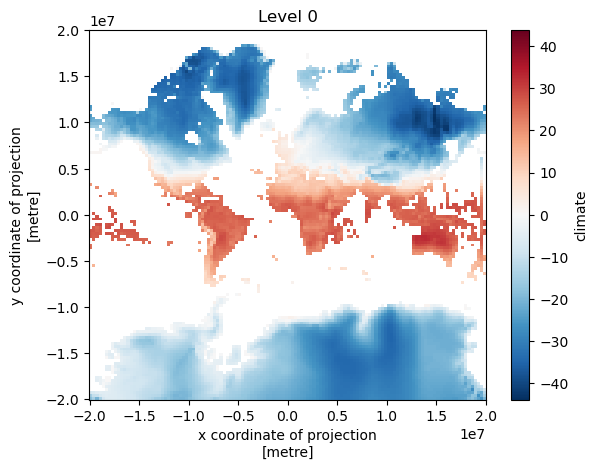

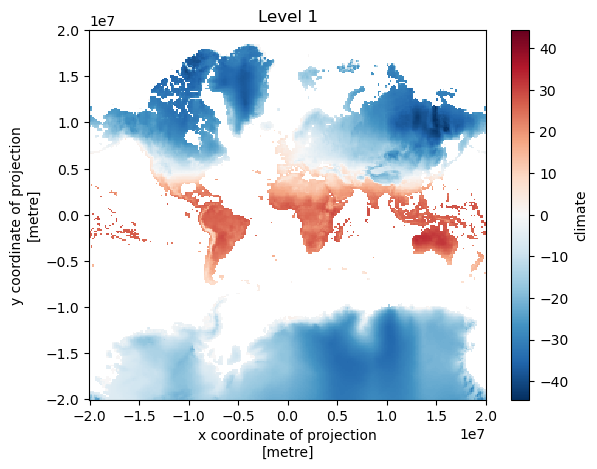

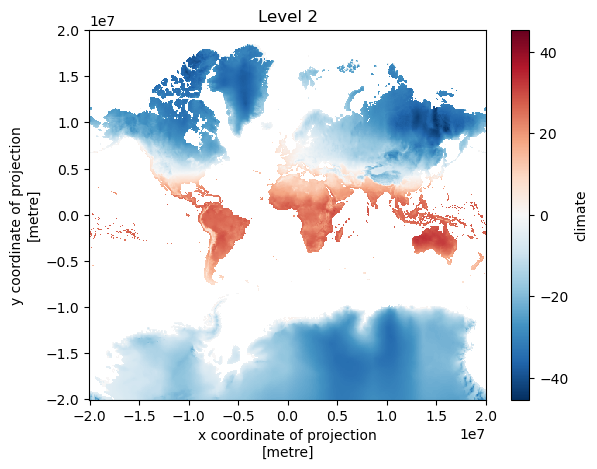

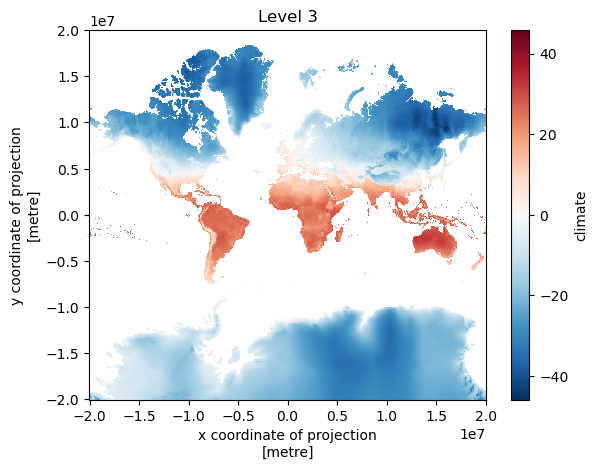

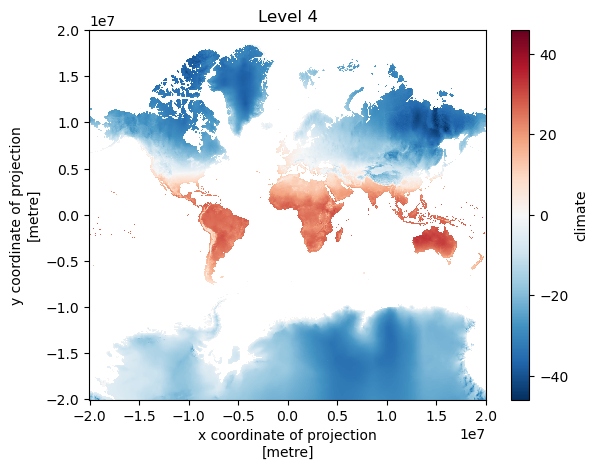

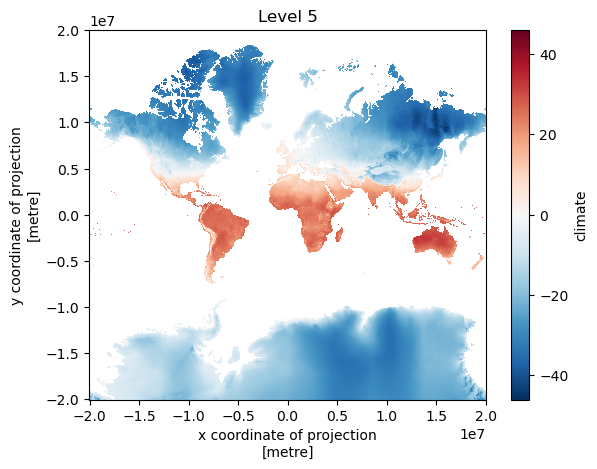

In [7]:
for level in range(LEVELS):
    fig, ax = plt.subplots()
    dt[str(level)].ds.isel(band=0, month=0).climate.plot()
    ax.set_title(f"Level {level}")